# Multilayer Perceptron -  Manual - Cross Validation

### Atualização dos pesos por iteração

### Importação das bibliotecas necessárias

In [1]:
import pandas as pd
from random import randint
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import explained_variance_score

### Carregamento da base

In [2]:
NomeBase = "BinariaGLCM50Poda1"
#base = pd.read_csv('Renato/atributosTeste50.txt', header=None)
valor = 1
base = pd.read_csv('bases/Base' + str(NomeBase)+'.csv', header=None)
entradas = base.iloc[:, 0:len(base.columns) -valor].values 
classes = base.iloc[:,len(base.columns)-valor].values
print(classes)
NumColunas = len(base.columns) - valor

[0 0 0 ... 1 1 1]


### Padronização dos dados

In [3]:
for i in range (len(base.columns)-valor):
    entradas[:,i] = (entradas[:,i] - np.mean(entradas[:,i]))/entradas[:,i].std(axis = 0)

### Transformação das classes para o tipo dummy

In [4]:
labelEncoder = LabelEncoder()
classes = labelEncoder.fit_transform(classes)

### Plotagem dos dados (colunas 1 e 2)

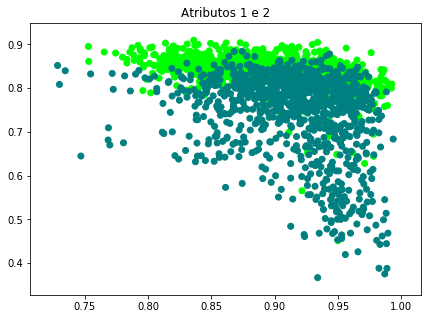

In [5]:
a1 = 1
a2 = 2

x = base.iloc[:,a1].values
y = base.iloc[:,a2].values

color= ['lime' if l == 0 else 'teal' if l == 1 else 'green' for l in classes]
plt.rcParams['figure.figsize'] = (7,5)
plt.title("Atributos "+ str(a1) + " e " + str(a2) )
plt.scatter(x, y, color=color)

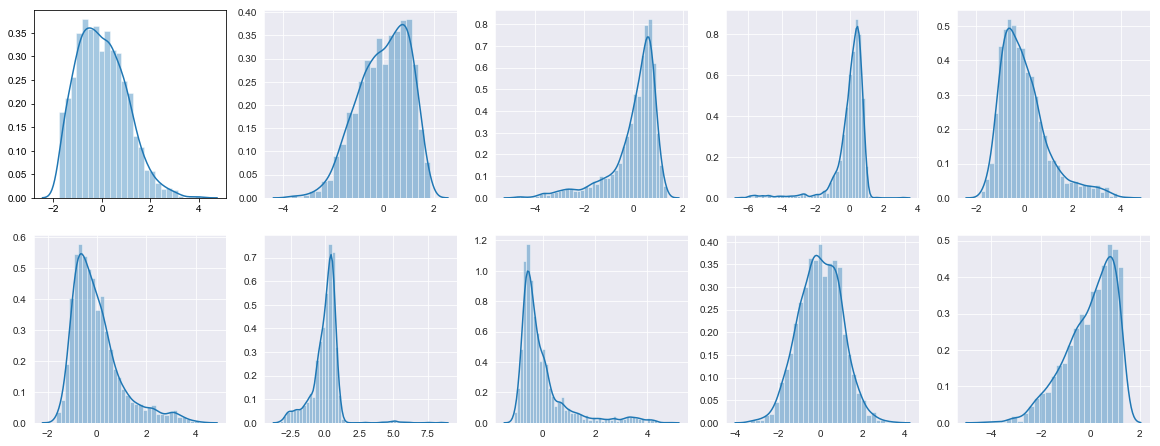

In [6]:


x = entradas.T
plt.rcParams['figure.figsize'] = (20,20)
for i in range(NumColunas):
    plt.subplot(5, 5, i+1)
    sns.set_style('darkgrid')
    sns.distplot(x[i])

### Divisão da base em treinamento (80%) e teste (20%)

In [7]:
def dividir_trei_test(entradas, classes, percentual):
    result = []
    while (len(result)) != len(entradas):
        r = randint(0, len(entradas)-1)
        if r not in result:
            result.append(r)    

    repeticoes = np.zeros(np.max(classes)+1)
    
    for i in range(len(entradas)):
        repeticoes[classes[i]] = repeticoes[classes[i]] + 1
    repeticoes = np.array(repeticoes)
    minimo = int(np.min(repeticoes) * (1 - percentual))
    
    treino = int((minimo) * (np.max(classes)+1) )
    teste = int(len(entradas) - treino)

    entradas_trei = np.zeros((treino, NumColunas))
    entradas_test = np.zeros((teste, NumColunas))
    classes_trei = np.zeros((treino)) 
    classes_test =np.zeros((teste))
 
    contTreino = 0
    contTest = 0
    vetorMinimo = np.zeros(np.max(classes)+1)

    for i in range(len(classes)):    
        if (vetorMinimo[classes[result[i]]] < minimo):            
            entradas_trei[contTreino] = entradas[result[i]]
            classes_trei[contTreino] = classes[result[i]]
            contTreino = contTreino + 1
            vetorMinimo[classes[result[i]]] = vetorMinimo[classes[result[i]]] + 1
            

        else:   
            entradas_test[contTest] = entradas[result[i]]            
            classes_test[contTest] = classes[result[i]]
            contTest = contTest + 1


    return entradas_trei, entradas_test, classes_trei, classes_test

In [8]:
labelEncoder = LabelEncoder()
classes = labelEncoder.fit_transform(classes)
NumClasses = np.max(classes) + 2

entradas_trei, entradas_test, classes_t, classes_te  = dividir_trei_test(entradas, classes, 0.2)
contador = np.zeros((3))

classes_test =  np.array(pd.get_dummies(classes_te))
classes_trei =  np.array(pd.get_dummies(classes_t))

### Métodos e demais variáveis necessárias

In [9]:
def funcaoAtivacao(soma, Usu_func):
    if (Usu_func == 1):
        return 1/(1 + np.exp(-soma))
    if (Usu_func == 2):
        return ((1 - np.exp(-soma))/(1 + np.exp(-soma)))
    return 0

In [10]:
def derivadaParcial(camadaSaida, Usu_func):
    if (Usu_func == 1):
        return camadaSaida * (1 - camadaSaida)
    if (Usu_func == 2):
        return 1/2 * (1 - (camadaSaida)**2)

In [11]:
def decaimentoTaxaAprend(realizar, tipo, taxaAprendIni, iteracaoAtual, NumIteracoes):
    if (realizar == 1):
        if (tipo == 1):
            # Linear
            return taxaAprendIni * (1 - (iteracaoAtual/NumIteracoes))            
        elif (tipo == 2):
            # Exponencial
             return taxaAprendIni/(1 + iteracaoAtual)  
    else:
        return taxaAprendIni
    

In [12]:
def CalcVar(camadaSaida, corretas):
    
    classesN = [np.argmax(t) for t in corretas]

    classesPreditas = np.zeros((camadaSaida.shape[0]))
    corretas = np.ones((camadaSaida.shape[0]))

    for i in range(camadaSaida.shape[0]):         
        classesPreditas[i] =  camadaSaida[i][classesN[i]]
    
    
    return np.var(classesPreditas)   

## Dados do usuário

In [13]:
NumClasses = np.max(classes) + 2
epocasAnt = 0
carregarPesos = int(input("Deseja carregar pesos salvos sem continuar a iteração? (1 - Sim, 2 - Não) "))

if (carregarPesos == 1):
        carregarPesCon = 0
        arquivo = input("Digite o número do diretório: ")  
        epocas = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/epocas.npy"))
        taxaAprendOcul = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/taxaAprendOcul.npy"))
        decaimentoOcul = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/decaimentoOcul.npy"))
        tipoDecaimentoOcul = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/tipoDecaimentoOcul.npy")) 
        taxaAprendSai = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/taxaAprendSai.npy"))         
        decaimentoSai = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/decaimentoSai.npy")) 
        tipoDecaimentoSai = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/tipoDecaimentoSai.npy")) 
        escolha = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/escolha.npy")) 
        NeuroniosCamadaOculta = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/NeuroniosCamadaOculta.npy")) 
        Usu_func = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/Usu_func.npy")) 
        TaxaRejeicao = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/TaxaRejeicao.npy")) 
        PesoBiasOculta = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/PesoBiasOculta.npy")) 
        pesos0 = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/pesos0.npy")) 
        pesos1 = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/pesos1.npy")) 
        Erro = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/Erro.npy")) 
        variancia = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/variancia.npy"))
        K = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/K.npy"))
        print(epocas)
        print(K)
if (carregarPesos != 1):    
    carregarPesCon = int(input("Deseja carregar pesos e continuar com o processamento? (1 - Sim, 2 - Não) "))
    dimensoes = NumColunas
    
    if (carregarPesCon == 1):
        arquivo = input("Digite o número do diretório: ")    
        epocasAnt =  np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/epocas.npy"))

        epocas = int(input('\033[1m' + "Digite a quantidade de épocas: "))
        epocasAnt = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/epocas.npy"))
        taxaAprendOcul = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/taxaAprendOcul.npy"))
        decaimentoOcul = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/decaimentoOcul.npy"))
        tipoDecaimentoOcul = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/tipoDecaimentoOcul.npy")) 
        taxaAprendSai = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/taxaAprendSai.npy")) 
        
        decaimentoSai = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/decaimentoSai.npy")) 
        tipoDecaimentoSai = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/tipoDecaimentoSai.npy")) 
        escolha = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/escolha.npy")) 
        NeuroniosCamadaOculta = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/NeuroniosCamadaOculta.npy")) 
        Usu_func = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/Usu_func.npy")) 
        TaxaRejeicao = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/TaxaRejeicao.npy")) 
        PesoBiasOculta = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/PesoBiasOculta.npy")) 
        pesos0 = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/pesos0.npy")) 
        pesos1 = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/pesos1.npy")) 
        Erro = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/Erro.npy")) 
        variancia = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/variancia.npy")) 
        K = np.load(str("resultados/pesosMLP_Base"+str(NomeBase)+"/"+str(arquivo)+"/K.npy"))
        
    else:
        epocas = int(input('\033[1m' + "Digite a quantidade de épocas: "))
        taxaAprendOcul = float(input('\033[1m' + "Digite a taxa de aprendizado da camada oculta: "))
        decaimentoOcul = int(input('\033[1m' + "Deseja realizar decaimento da taxa de aprendizagem da camada Oculta? (1 - Sim ou 2 - Não): "))
        if (decaimentoOcul == 1):
            print('\033[1m' + "Digite: ")
            print('\033[1m' + "1- Decaimento Linear: ")
            print('\033[1m' + "2- Decaimento exponencial: ")
            tipoDecaimentoOcul = int(input(""))
        else:
            tipoDecaimentoOcul = 0
        taxaAprendSai = float(input('\033[1m' + "Digite a taxa de aprendizado da camada de saída: "))
        taxaAprendSaiIni = taxaAprendSai
        decaimentoSai = int(input('\033[1m' + "Deseja realizar decaimento da taxa de aprendizagem da camada de Saída? (1 - Sim ou 2 - Não): "))
        if (decaimentoSai == 1):
            print('\033[1m' + "Digite: ")
            print('\033[1m' + "1- Decaimento Linear: ")
            print('\033[1m' + "2- Decaimento exponencial: ")
            tipoDecaimentoSai = int(input(""))
        else:
            tipoDecaimentoSai = 0
        print('\033[1m' + "Digite a quantidade de Neurônios da camada oculta: ")
        print("1- Regra do Valor Médio")
        print("2- Regra de Kolmogorov")
        print("3- Regra de Fletcher-Gloss")
        print("4- Regra da Raiz quadrada")
        print("5- Inserir um valor manualmente")
        escolha = int(input(""))
        if (escolha == 1):
                # Regra do valor médio
                qtde =  int((NumClasses + NumColunas)/2)
        if (escolha == 2):
                # Regra de Kolmogorov
                qtde =  int((2 * NumColunas) + 1)
        if (escolha == 3):
                # Regra de Fletcher-Gloss
                a = int((2* (NumColunas ** (1/2)) + NumClasses))
                b = 2 * NumColunas + 1
                qtde = int(randint(a, b))      
        if (escolha == 4):
                # Regra da raiz quadrada
                qtde = int((NumClasses * NumColunas)**(1/2))
        if (escolha == 5):
                qtde = int(input("Digite a quantidade de neurônios que deseja inserir"))
        NeuroniosCamadaOculta = qtde
        print(NeuroniosCamadaOculta)
        print('\033[1m' + "Função de ativação: ")
        print("1- Logística")
        print("2- Tangente Hiperbólica")
        Usu_func = int(input("Digite o valor: "))
        TaxaRejeicao = float(input("Digite o valor para a Faixa de Rejeição: "))        
        print('\033[1m' + "Validação Cruzada - K-fold ")
        K = int(input("Digite a quantidade de partes para a Validação Cruzada: "))
        
        PesoBiasOculta = np.dot((-0.5 + (0.5 + 0.5)), np.random.random((NeuroniosCamadaOculta,1)))
        MelhorPeso0 = np.zeros((NumColunas,NeuroniosCamadaOculta))
        MelhorPeso1 = np.zeros(NeuroniosCamadaOculta, NumClasses)
        pesos0 = np.dot((-0.5 + (0.5 + 0.5)), np.random.random((NumColunas,NeuroniosCamadaOculta)))
        pesos1 = np.dot((-0.5 + (0.5 + 0.5)), np.random.random((NeuroniosCamadaOculta, NumClasses)))

taxaAprendOculIni = taxaAprendOcul
taxaAprendSaiIni = taxaAprendSai

Deseja carregar pesos salvos sem continuar a iteração? (1 - Sim, 2 - Não) 1
Digite o número do diretório: 23
30
10


### Validação Cruzada

In [14]:
def SepararTeste(a, inicio, fim, tamanho, NumColunas):
    aux = 0
    x = np.zeros((tamanho, NumColunas))    
    while (inicio < fim):
        x[aux] = a[inicio]
        aux = aux + 1
        inicio = inicio + 1
    return(x)

In [15]:
def SepararTreino(a, inicio, fim, tamanho, NumColunas):
    aux = 0
    x = np.zeros(((len(a) - tamanho), NumColunas))    
    for i in range(len(a)):
        if ((i < inicio) or (i >= fim)):
            x[aux] = a[i]
            aux = aux + 1
    return(x)

### Acrescenta uma coluna para os valores da Taxa de Rejeição

In [16]:
temp = classes_trei
num_entradas_trei = len(entradas_trei)
classes_trei = np.zeros((num_entradas_trei, NumClasses))

for i in range(num_entradas_trei):
    for j in range(NumClasses-1):
        classes_trei[i][j] = temp[i][j]  
    
camadaSaida = np.zeros((num_entradas_trei, NumClasses))

#for i in range(classes_trei.shape[0]):
#    print(classes_trei[i])
    
menorErro = 10000
melhorEpoca = epocas

## Treinamento

In [17]:
if (carregarPesos != 1):
    mediaErroTest_Val = np.zeros(epocas)
   # menorErro = np.zeros(epocas + 1)
    
    mediaErro = np.zeros(epocas)    
    variancia = np.zeros(epocas)
    Erro = np.zeros(num_entradas_trei)    
    
    for i in range(epocas):            
        tamanho = int(len(entradas_trei)/K)
        inicio = 0
        fim = tamanho
        camadaSaida_Val = np.zeros((tamanho, NumClasses))
        #print("epoca " + str(i))
        
        for m in range(K): 
           # print("K " + str(m))
            entradas_trei_val = SepararTreino(entradas_trei, inicio, fim, tamanho, NumColunas)
            classes_trei_val = SepararTreino(classes_trei, inicio, fim, tamanho, NumClasses)
            
            entradas_val = SepararTeste(entradas_trei, inicio, fim, tamanho, NumColunas)
            classes_val = SepararTeste(classes_trei, inicio, fim, tamanho, NumClasses)
            
            # iteração
            for j in range(entradas_trei_val.shape[0]):
            
                # Feed Foward
                entrada = entradas_trei_val[j].reshape(1,NumColunas)
                somaSinapse0 = np.dot(entrada, pesos0)        
                camadaOculta = funcaoAtivacao(somaSinapse0 - PesoBiasOculta.T, Usu_func)  
                soma = np.dot(camadaOculta, pesos1)
                camadaSaida[j]  = funcaoAtivacao(soma, Usu_func)

                # Back Propagation
                erroCamadaSaida = classes_trei_val[j] - camadaSaida[j]
                Erro[j] =  np.mean(np.abs(erroCamadaSaida))
                
                # Atualização dos pesos                
                derivadaSaida  = derivadaParcial(camadaSaida[j], Usu_func)
                GradienteSaida = derivadaSaida * erroCamadaSaida
                GradienteSaida = GradienteSaida.reshape(1,NumClasses) 
                pesos1 = pesos1 + taxaAprendSai * camadaOculta.T * GradienteSaida 
                DerivadaOculta = derivadaParcial(camadaOculta, Usu_func)
                GradienteOculta = (DerivadaOculta.T * (np.dot(pesos1, GradienteSaida.T)))
                pesos0 = pesos0 + taxaAprendOcul * (entrada.T * GradienteOculta.T);        

                # Decaimento da taxa de Aprendizagem
                taxaAprendOcul = decaimentoTaxaAprend(decaimentoOcul, tipoDecaimentoOcul, taxaAprendOculIni, j, num_entradas_trei)
                taxaAprendSai = decaimentoTaxaAprend(decaimentoSai, tipoDecaimentoSai, taxaAprendSaiIni, j, num_entradas_trei)
                
                                
            # Validação
           # mediaErroTest_Val = np.zeros(entradas_val.shape[0])
            for n in range(entradas_val.shape[0]):     
                    # Feed Foward
                entrada_v = entradas_val[n].reshape(1, NumColunas)
                somaSinapse0_v = np.dot(entrada_v, pesos0)        
                camadaOculta_v = funcaoAtivacao(somaSinapse0_v + PesoBiasOculta.T, Usu_func)        
                camadaSaida_Val[n] = funcaoAtivacao(np.dot(camadaOculta_v, pesos1), Usu_func)

                # Variância
                varianciaVal = CalcVar(classes_val, camadaSaida_Val)

                # cálculo do erro
                erroCamadaSaida_Val = classes_val - camadaSaida_Val
                
                # Média absoluta do erro
                                
            # Atualização dos campos para a validação cruzada
            inicio = inicio + tamanho
            fim = tamanho + fim
            ErroK = np.mean(np.abs(Erro))
            
        mediaErroTest_Val[i] = np.mean(np.abs(erroCamadaSaida_Val))

        if (mediaErroTest_Val[i] < menorErro):
            menorErro = mediaErroTest_Val[i]
            melhorEpoca = i
            MelhorPeso0 = pesos0
            MelhorPeso1 = pesos1        
        print("Época atual: "+ str(i))
        print("Melhor época: "+ str(melhorEpoca))
        print("Menor Erro: "+ str(menorErro))
        print("Erro na validação: "+ str(mediaErroTest_Val[i]))
   
                
        mediaErro[i] = np.mean(np.abs(ErroK)) 
        variancia[i] = CalcVar(classes_trei, camadaSaida)        

In [19]:
if (carregarPesos != 1):
    plt.rcParams['figure.figsize'] = (20, 8)
    plt.subplot(1, 3, 1)
    plt.title("Erro Médio do Treinamento: "+ str(np.mean(np.abs(mediaErro))))
    plt.plot(mediaErro)   

    plt.subplot(1, 3, 2)
    plt.title("Variância")
    plt.plot(variancia)

    plt.subplot(1, 3, 3)
    plt.title("Menor Erro Médio da Validação: "+ str(menorErro) + str( " \n Melhor época: "+ str(melhorEpoca)))
    plt.plot(mediaErroTest_Val)

## Resultados obtidos com os pesos finais

In [20]:
camadaSaidaTrei = np.zeros((num_entradas_trei, NumClasses))

varianciaTrei = np.zeros((num_entradas_trei))

for j in range(num_entradas_trei):     
    # Feed Foward
    entrada = entradas_trei[j].reshape(1, NumColunas)
    somaSinapse0 = np.dot(entrada, pesos0)        
    camadaOculta = funcaoAtivacao(somaSinapse0 + PesoBiasOculta.T, Usu_func)        
    camadaSaidaTrei[j]  = funcaoAtivacao(np.dot(camadaOculta, pesos1), Usu_func)
    
# Variância
varianciaTrei = CalcVar(classes_trei, camadaSaidaTrei)
    
# cálculo do erro
erroCamadaSaida = classes_trei - camadaSaidaTrei

# Média absoluta do erro
mediaErroTrei = np.mean(np.abs(erroCamadaSaida))
print("Média Absoluta do Erro: "+ str(mediaErroTrei))
print("Variância: "+ str(varianciaTrei))


Média Absoluta do Erro: 0.06745193172696039
Variância: 0.0743141693073789


## Resultados obtidos com os melhores pesos segundo o cross-validation

In [21]:
if (carregarPesos != 1):
    camadaSaidaTrei = np.zeros((num_entradas_trei, NumClasses))

    varianciaTrei = np.zeros((num_entradas_trei))

    for j in range(num_entradas_trei):     
        # Feed Foward
        entrada = entradas_trei[j].reshape(1, NumColunas)
        somaSinapse0 = np.dot(entrada, MelhorPeso0)        
        camadaOculta = funcaoAtivacao(somaSinapse0 + PesoBiasOculta.T, Usu_func)        
        camadaSaidaTrei[j]  = funcaoAtivacao(np.dot(camadaOculta, MelhorPeso1), Usu_func)

    # Variância
    varianciaTrei = CalcVar(classes_trei, camadaSaidaTrei)

    # cálculo do erro
    erroCamadaSaida = classes_trei - camadaSaidaTrei

    # Média absoluta do erro
    mediaErroTrei = np.mean(np.abs(erroCamadaSaida))
    print("Média Absoluta do Erro: "+ str(mediaErroTrei))
    print("Variância: "+ str(varianciaTrei))
    #print(camadaSaidaTrei)
    
    
    caminho = 'resultados/pesosMLP_Base'+str(NomeBase)
    valor  = 0
    import os

    if not os.path.exists(str(caminho)+"/"+str(int(valor))):
        os.mkdir(str(caminho)+ "/" + str(int(valor)))    

    else:       
        b = os.listdir(caminho)
        a = np.zeros(len(b))

        for i in range(len(b)):
            a[i] = int(b[i])

        valor = np.max(a)
        valor = valor + 1

        os.mkdir(str(caminho) + "/"+ str(int(valor)))
    
    np.save(str(caminho) + "/"+ str(int(valor))+"/epocas", epocas)
    np.save(str(caminho) + "/"+ str(int(valor))+"/taxaAprendOcul", taxaAprendOcul)
    np.save(str(caminho) + "/"+ str(int(valor))+"/decaimentoOcul", decaimentoOcul)
    np.save(str(caminho) + "/"+ str(int(valor))+"/tipoDecaimentoOcul", tipoDecaimentoOcul)
    np.save(str(caminho) + "/"+ str(int(valor))+"/taxaAprendSai", taxaAprendSai)
    np.save(str(caminho) + "/"+ str(int(valor))+"/decaimentoSai", decaimentoSai)
    np.save(str(caminho) + "/"+ str(int(valor))+"/tipoDecaimentoSai", tipoDecaimentoSai)
    np.save(str(caminho) + "/"+ str(int(valor))+"/escolha", escolha)
    np.save(str(caminho) + "/"+ str(int(valor))+"/NeuroniosCamadaOculta", NeuroniosCamadaOculta)
    np.save(str(caminho) + "/"+ str(int(valor))+"/Usu_func", Usu_func)
    np.save(str(caminho) + "/"+ str(int(valor))+"/TaxaRejeicao", TaxaRejeicao)
    np.save(str(caminho) + "/"+ str(int(valor))+"/PesoBiasOculta", PesoBiasOculta)
    np.save(str(caminho) + "/"+ str(int(valor))+"/pesos0", MelhorPeso0)
    np.save(str(caminho) + "/"+ str(int(valor))+"/pesos1", MelhorPeso1)
    np.save(str(caminho) + "/"+ str(int(valor))+"/Erro", Erro)
    np.save(str(caminho) + "/"+ str(int(valor))+"/variancia", variancia)
    np.save(str(caminho) + "/"+ str(int(valor))+"/K", K)

### Taxa de Rejeição

In [22]:
for i in range(len(camadaSaidaTrei)):
    a = camadaSaidaTrei[i]
    b = np.sort(a)   
    if ((b[len(b)-1] - b[len(b)-2]) <= TaxaRejeicao):        
        for j in range (camadaSaidaTrei.shape[1]-1):
            camadaSaidaTrei[i][j] = 0
        camadaSaidaTrei[i][camadaSaidaTrei.shape[1]-1] = 1

In [23]:
mediaErroTrein = str(np.mean(np.abs(mediaErroTrei)))

### Organização das Saídas para plotagem da Matriz de Confusão

In [24]:
SaidasCalcTrein =  [np.argmax(t) for t in camadaSaidaTrei]
classesN = [np.argmax(t) for t in classes_trei]

classesPreditas = np.zeros((camadaSaidaTrei.shape[0]))

for i in range(camadaSaidaTrei.shape[0]):         
    classesPreditas[i] =  camadaSaidaTrei[i][classesN[i]]
    
print("Variância entre as saídas calculadas "+ str(np.var(classesPreditas)))

Variância entre as saídas calculadas 0.06682411475353998


In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Matriz de Confusão',
                          cmap=plt.cm.Blues):   

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Saída correta')
    plt.xlabel('Saída encontrada')    

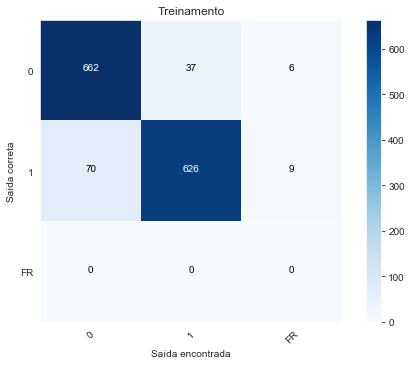

In [26]:
plt.rcParams['figure.figsize'] = (7,5)
sns.set_style("dark")
cm = confusion_matrix(classesN, SaidasCalcTrein)
plot_confusion_matrix(cm, 
                      classes=['0', '1','FR'],
                      title='Treinamento')



### Taxa de Erro retirando os valores que entraram na taxa de rejeição

In [27]:
quantTotal = 0;
NClasses = NumClasses - 2

for i in range(len(SaidasCalcTrein)):
    if (SaidasCalcTrein[i] <= NClasses):
        quantTotal += 1
erros = 0

for i in range (len(SaidasCalcTrein)):
    if ((SaidasCalcTrein[i] != classesN[i]) and (SaidasCalcTrein[i] <= NClasses)):
        erros += 1

Taxa_de_erro_Trei =  (erros * 100)/quantTotal
acerto_trei = 100 - Taxa_de_erro_Trei
print("Taxa de erro desconsiderando as saídas que entraram na taxa de rejeição: "+str(Taxa_de_erro_Trei))
print("Percentual de acerto: "+ str(100 - Taxa_de_erro_Trei))

Taxa de erro desconsiderando as saídas que entraram na taxa de rejeição: 7.670250896057348
Percentual de acerto: 92.32974910394265


## Testes

### Acrescenta uma coluna para os valores da Taxa de Rejeição

In [28]:
num_entradas_test = len(entradas_test)
tempTest = classes_test
classes_test = np.zeros((num_entradas_test, NumClasses))

for i in range(num_entradas_test):
    for j in range(NumClasses-1):
        classes_test[i][j] = tempTest[i][j]  

In [29]:
camadaSaidaTest = np.zeros((num_entradas_test, NumClasses))
varianciaTest = np.zeros((num_entradas_test))

for j in range(num_entradas_test):     
    # Feed Foward
    entrada = entradas_test[j].reshape(1,NumColunas)
    somaSinapse0 = np.dot(entrada, pesos0)        
    camadaOculta = funcaoAtivacao(somaSinapse0 + PesoBiasOculta.T, Usu_func)        
    camadaSaidaTest[j]  = funcaoAtivacao(np.dot(camadaOculta, pesos1), Usu_func)
    
# Variância
varianciaTest = CalcVar(classes_test, camadaSaidaTest)
    
# cálculo do erro
erroCamadaSaida = classes_test - camadaSaidaTest

# Média absoluta do erro
mediaErroTest = np.mean(np.abs(erroCamadaSaida))
print("Média Absoluta do Erro: "+ str(mediaErroTest))
print("Variância: "+ str(varianciaTest))

Média Absoluta do Erro: 0.08416065990869809
Variância: 0.10232928433859004


### Taxa de Rejeição

In [30]:
for i in range(len(camadaSaidaTest)):
    a = camadaSaidaTest[i]
    b = np.sort(a)   
    if ((b[len(b)-1] - b[len(b)-2]) <= TaxaRejeicao):        
        for j in range (camadaSaidaTest.shape[1]-1):
            camadaSaidaTest[i][j] = 0
        camadaSaidaTest[i][camadaSaidaTest.shape[1]-1] = 1

### Organização das Saídas para plotagem da Matriz de Confusão

In [31]:
classesN = [np.argmax(t) for t in classes_test]

In [32]:
SaidasCalcTest =  [np.argmax(t) for t in camadaSaidaTest]

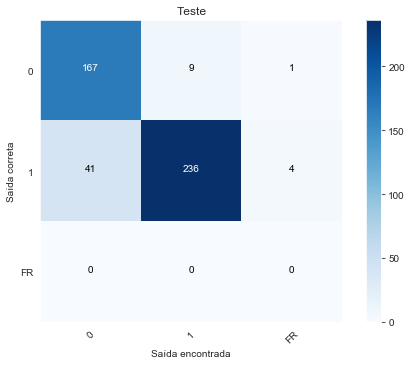

In [33]:
cm = confusion_matrix(classesN, SaidasCalcTest)
plot_confusion_matrix(cm, 
                      classes=['0', '1', 'FR'],
                      title='Teste')

### Taxa de Erro retirando os valores que entraram na taxa de rejeição

In [34]:
quantTotal = 0;
NClasses = NumClasses - 2

for i in range(len(SaidasCalcTest)):
    if (SaidasCalcTest[i] <= NClasses):
        quantTotal += 1
erros = 0

for i in range (len(SaidasCalcTest)):
    if ((SaidasCalcTest[i] != classesN[i]) and (SaidasCalcTest[i] <= NClasses)):
        erros += 1

Taxa_de_erro_Test =  (erros * 100)/quantTotal
acerto_test = 100 - Taxa_de_erro_Test
print("Taxa de erro desconsiderando as saídas que entraram na taxa de rejeição: "+str(Taxa_de_erro_Test))
print("Percentual de acerto: "+ str(100 - Taxa_de_erro_Test))

Taxa de erro desconsiderando as saídas que entraram na taxa de rejeição: 11.037527593818984
Percentual de acerto: 88.96247240618102


### Criar DataSet das Informações sobre as execuções

#### Abre o arquivo

In [35]:
 if (carregarPesos != 1):  
            arquivo = open('resultados/Base'+str(NomeBase)+'Dados.txt', 'r')
            conteudo = arquivo.readlines()
        
            conteudo.append("\n"+str(epocas+epocasAnt)+", "+ str(taxaAprendOculIni)+", "+ str(taxaAprendOcul)+", "+ str(decaimentoOcul)+", "+ str(tipoDecaimentoOcul)+", "+ str(taxaAprendSaiIni) +", "+ str(taxaAprendSai)+", "+ str(decaimentoSai)+", "+ str(tipoDecaimentoSai)+","+ str(escolha) +", "+ str(NeuroniosCamadaOculta)+", "+ str(Usu_func)+", "+str(TaxaRejeicao)+", "+str(K)+", "+ str(variancia[len(variancia)-1])+", "+ str(varianciaTest)+ ", "+str(mediaErroTrein)+", "+str(mediaErroTest)+ ", "+ str(acerto_trei)+ ","+ str(acerto_test))

            #### Abre o arquivo como escrita, escreve o conteúdo e fecha o mesmo
        
            arquivo = open('resultados/Base'+str(NomeBase)+'Dados.txt', 'w')
            arquivo.writelines(conteudo)
            arquivo.close()

#### Leitura dos dados existentes

In [36]:
arquivo = pd.read_csv('resultados/Base'+str(NomeBase)+'Dados.txt')
arquivo = arquivo.sort_values(by=[' MediaErroTest', ' MediaErroTrei'], ascending=True)
print("10 Melhores Resultados - Base "+ str(NomeBase))

arquivo.head(20)

10 Melhores Resultados - Base BinariaGLCM50Poda1


,epocas,taxaAprendOculIni,taxaAprendOcul,decaimentoOcul,tipoDecaimentoOcul,taxaAprendSaiIni,taxaAprendSai,decaimentoSai,tipoDecaimentoSai,escolha,NeuroniosCamadaOculta,Usu_func,TaxaRejeicao,K-folds,VarianciaTrei,VarianciaTest,MediaErroTrei,MediaErroTest,Taxa_de_acerto_Trei,Taxa_de_acerto_Test
23,100,0.4,0.040284,1,1,0.3,0.030213,1,1,2,21,1,0.1,10,0.249660,0.102329,0.060949,0.079064,92.241993,88.766520
5,64,0.2,0.020080,1,1,0.3,0.030120,1,1,11,11,1,0.1,10,0.112991,0.082645,0.078509,0.079201,91.578947,90.909091
35,200,0.4,0.400000,2,0,0.4,0.400000,2,0,2,21,1,0.1,30,0.050362,0.104003,0.047320,0.079332,93.527738,88.209607
14,218,0.2,0.200000,2,0,0.4,0.400000,2,0,38,38,1,0.2,7,0.107991,0.109876,0.054033,0.083332,94.641450,88.108108
31,60,0.5,0.500000,2,0,0.4,0.400000,2,0,2,21,1,0.1,10,0.077863,0.104003,0.059883,0.087866,93.066476,88.938053
10,34,0.3,0.300000,2,0,0.5,0.500000,2,0,40,40,1,0.2,11,0.117414,0.117769,0.066550,0.088814,91.934279,87.912088
25,50,0.5,0.500000,2,0,0.2,0.020142,1,1,3,19,1,0.1,10,0.249311,0.102329,0.085546,0.088859,91.338583,88.766520
26,50,0.5,0.500000,2,0,0.2,0.020142,1,1,3,19,1,0.1,10,0.249311,0.102329,0.085546,0.088859,91.338583,88.766520
24,300,0.3,0.018936,1,1,0.1,0.100000,2,0,2,21,1,0.1,16,0.249968,0.107321,0.073825,0.092058,91.696751,88.300221
21,99,0.2,0.200000,2,0,0.2,0.200000,2,0,38,38,1,0.2,8,0.113486,0.113851,0.062520,0.092208,93.618677,88.010899


# Resultados obtidos

In [37]:
print("\n Épocas: \t \t \t \t \t \t \t \t"+str(epocas+epocasAnt)+
      " \n Taxa de Aprendizado Inicial da Camada Oculta: \t \t \t \t"+ str(taxaAprendOculIni)+
      " \n Taxa de Aprendizado Final da Camada Oculta: \t \t \t \t"+ str(taxaAprendOcul)+
      " \n Decaimento da Taxa de Aprendizado da Camada Oculta: \t \t \t"+ str(decaimentoOcul)+
      " \n Tipo de Decaimento da Taxa de Aprendizado da Camada Oculta: \t  \t"+ str(tipoDecaimentoOcul)+
      " \n Taxa de Aprendizado Inicial da Camada de Saída:  \t \t \t"+ str(taxaAprendSaiIni) +
      " \n Taxa de Aprendizado Final da Camada de Saída:  \t \t \t"+ str(taxaAprendSai)+
      " \n Decaimento da Taxa de Aprendizado da Camada de Saída:  \t \t"+ str(decaimentoSai)+
      " \n Tipo de Decaimento da Taxa de Aprendizado da Camada Oculta:  \t \t"+ str(tipoDecaimentoSai)+
      " \n Escolha do método da quantidade de Neurônios da Camada Oculta: \t"+ str(escolha) +
      " \n Quantidade de Neurônios da Camada Oculta: \t \t \t \t"+ str(NeuroniosCamadaOculta)+
      " \n Função de Ativação: \t \t \t \t \t \t \t"+ str(Usu_func)+
      " \n Taxa de Rejeição: \t \t \t \t \t \t \t"+str(TaxaRejeicao)+
      " \n Variância do Treinamento: \t \t \t \t \t \t"+ str(variancia[len(variancia)-1])+
      " \n Variância dos Testes: \t \t \t \t \t \t \t"+ str(varianciaTest)+ 
      " \n Erro Médio do Treinamento: \t \t \t \t \t \t"+str(mediaErroTrein)+
      " \n Erro Médio do Teste: \t \t \t \t \t \t \t"+str(mediaErroTest)+ 
      " \n Taxa de Erro do Treinamento (excluíndo os valores da TR): \t \t"+ str(Taxa_de_erro_Trei)+ 
      " \n Taxa de Erro do Teste (excluíndo os valores da TR): \t \t \t"+ str(Taxa_de_erro_Test))


 Épocas: 	 	 	 	 	 	 	 	30 
 Taxa de Aprendizado Inicial da Camada Oculta: 	 	 	 	0.5 
 Taxa de Aprendizado Final da Camada Oculta: 	 	 	 	0.5 
 Decaimento da Taxa de Aprendizado da Camada Oculta: 	 	 	2 
 Tipo de Decaimento da Taxa de Aprendizado da Camada Oculta: 	  	0 
 Taxa de Aprendizado Inicial da Camada de Saída:  	 	 	0.4 
 Taxa de Aprendizado Final da Camada de Saída:  	 	 	0.4 
 Decaimento da Taxa de Aprendizado da Camada de Saída:  	 	2 
 Tipo de Decaimento da Taxa de Aprendizado da Camada Oculta:  	 	0 
 Escolha do método da quantidade de Neurônios da Camada Oculta: 	2 
 Quantidade de Neurônios da Camada Oculta: 	 	 	 	21 
 Função de Ativação: 	 	 	 	 	 	 	1 
 Taxa de Rejeição: 	 	 	 	 	 	 	0.1 
 Variância do Treinamento: 	 	 	 	 	 	0.08499934770816689 
 Variância dos Testes: 	 	 	 	 	 	 	0.10232928433859004 
 Erro Médio do Treinamento: 	 	 	 	 	 	0.06745193172696039 
 Erro Médio do Teste: 	 	 	 	 	 	 	0.08416065990869809 
 Taxa de Erro do Treinamento (excluíndo os valores